In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def z_test(df, by, value, features, kde=False):
    
    #subset only by and value columns and remove NaN
    clean = df[[by,value]].dropna()

    #further subset the value column based on by
    df1 = clean[clean[by] == features[0]][value]
    df2 = clean[clean[by] == features[1]][value]
    
    n1 = len(df1)
    X1 = df1.mean()
    s1 = df1.std()
    
    n2 = len(df2)
    X2 = df2.mean()
    s2 = df2.std()
    
    zscore = (X1-X2)/(np.sqrt((s1/np.sqrt(n1))**2 + (s2/np.sqrt(n2))**2))
    pvalue = stats.norm.sf(abs(zscore))*2
    significant = pvalue < 0.05
    
    print('{}[{} == {}] mean={:.2f}, std={:.3f}'.format(value,by, features[0], X1, s1))
    print('{}[{} == {}] mean={:.2f}, std={:.3f}'.format(value,by, features[1], X2, s2))
    
    print('z_score = {:.2f}, pvalue = {:.3f}, significantly different - {}'.format(zscore, pvalue, significant))
    
    import warnings
    warnings.filterwarnings("ignore")
    
    sns.distplot(df1, bins=50, label=str(features[0]), kde=kde)
    sns.distplot(df2, bins=50, label=str(features[1]), kde=kde)
    plt.axvline(x=X1, c='black')
    plt.axvline(x=X2, c='black')
    plt.legend()
    
    warnings.filterwarnings("default")

In [4]:
def model_statistics(model, features, y_true, y_pred, y_pred_prob):
    
    print("--------------------- Confusion Matrix ---------------------")
    print(metrics.confusion_matrix(y_true, y_pred))
    print('\n')
    
    print("--------------------- Classification Report ---------------------")
    print(metrics.classification_report(y_true, y_pred))
    print('\n')
    
    #print("--------------------- ROC Curve ---------------------")
    #area under the curve
    AUC = metrics.roc_auc_score(y_true, y_pred_prob[:,1])
    
    #false positive and true positive rates
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob[:,1])
    
    #plotting the figure
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr,tpr, label='AUC = %0.4f'% AUC)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='upper left')
    print('\n')
    
    #print("--------------------- Feature Importances ---------------------")
    #summary = pd.Series(model.feature_importances_)
    #summary.index = features
    
    #summary.sort_values(ascending=False, inplace=True)
    
    #plt.figure(figsize=(8,10))
    #sns.barplot(y=summary.index.values[:50], x=summary.values[:50])

In [5]:
def regress_log(X,y_true):
    from sklearn import linear_model
    
    model = linear_model.LogisticRegression()
    
    model.fit(X,y_true)
    
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)
    
    model_statistics(model, X.columns, y_true, y_pred, y_pred_prob)

In [6]:
def decision_tree(X,y_true):
    from sklearn.tree import DecisionTreeClassifier
    
    model = DecisionTreeClassifier(max_features=None,
                                   min_samples_leaf=1000,
                                   min_samples_split=15000,
                                   max_depth=5
                                  )
    
    model.fit(X,y_true)
    
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)
    
    model_statistics(model, X.columns, y_true, y_pred, y_pred_prob)
    
    return model

In [7]:
# loading train dataset
train_csv = pd.read_csv('../input/application_train.csv.zip', compression='infer')

In [8]:
train_csv.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
num_total = len(train_csv)
num_approved = len(train_csv[train_csv['TARGET'] == 1])
num_refused = len(train_csv[train_csv['TARGET'] == 0])

print('Percantage approved: {:.2%}, support {:d}'.format(num_approved/num_total, num_approved))
print('Percantage refused: {:.2%}, support {:d}'.format(num_refused/num_total, num_refused))

del num_approved, num_refused, num_total

Percantage approved: 8.07%, support 24825
Percantage refused: 91.93%, support 282686


What I've Learned:
* There is a huge bias towards refusal in the provided dataset approximately 9:1

In [10]:
pd.DataFrame(train_csv['CODE_GENDER'].value_counts())

,CODE_GENDER
F,202448
M,105059
XNA,4


What I've Learned:
* Ratio of female to male is approximately 2:1

In [11]:
pd.crosstab(train_csv['CODE_GENDER'], train_csv['TARGET'], normalize='index')

TARGET,0,1
CODE_GENDER,,
F,0.930007,0.069993
M,0.898581,0.101419
XNA,1.000000,0.000000


What I've Learned:
* Men are approximately twice more likely to get approved than women, however this doesn't imply cousation.

In [12]:
pd.crosstab(train_csv['CODE_GENDER'], train_csv['TARGET'], train_csv['AMT_INCOME_TOTAL'], aggfunc=('mean'))

TARGET,0,1
CODE_GENDER,,
F,155984.245110,156670.941531
M,195190.418791,177502.085687
XNA,186750.000000,NaN


What I've Learned:
* Average Total Income doesn't seem to influence the approval decision, mean incomes for approved and rejected are almost identical for both males and females.
* It is interesting that the mean income of the rejected males is **bigger** than this of the approved males.

In [13]:
pd.crosstab(train_csv['CODE_GENDER'], 
            train_csv['TARGET'], 
            train_csv['AMT_CREDIT']/train_csv['AMT_INCOME_TOTAL'], 
            aggfunc='mean')

TARGET,0,1
CODE_GENDER,,
F,4.198972,4.229110
M,3.494640,3.433052
XNA,2.185982,NaN


What I've Learned:
* The ratio between credit and income doesn't predict approval or refusal, either for males or females
* Credit/Income ratio for females is bigger than men. Interestingly their income is slightly smaller than the males'

In [14]:
pd.crosstab(train_csv['FLAG_OWN_REALTY'], train_csv['TARGET'], normalize='index')

TARGET,0,1
FLAG_OWN_REALTY,,
N,0.916751,0.083249
Y,0.920384,0.079616


What I've Learned:
* Owning realty doesn't predict approval or refusal

In [15]:
pd.crosstab(train_csv['FLAG_OWN_REALTY'], train_csv['CODE_GENDER'] , train_csv['TARGET'], aggfunc='mean')

CODE_GENDER,F,M,XNA
FLAG_OWN_REALTY,,,
N,0.072993,0.100466,NaN
Y,0.068758,0.101899,0.0


What I've Learned:
* Men who own realty are more likely to get a loan than women who own realty

In [16]:
pd.crosstab(train_csv['CODE_GENDER'], train_csv['CNT_CHILDREN'], train_csv['TARGET'], aggfunc='mean')

CNT_CHILDREN,0,1,2,3,4,5,6,7,8,9,10,11,12,14,19
CODE_GENDER,,,,,,,,,,,,,,,
F,0.064784,0.080503,0.086195,0.098635,0.135135,0.098039,0.400000,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0
M,0.102563,0.104060,0.088831,0.092669,0.117647,0.060606,0.181818,0.0,0.0,1.0,NaN,1.0,NaN,0.0,NaN
XNA,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


EXT_SOURCE_3[TARGET == 0] mean=0.52, std=0.190
EXT_SOURCE_3[TARGET == 1] mean=0.39, std=0.206
z_score = 84.58, pvalue = 0.000, significantly different - True


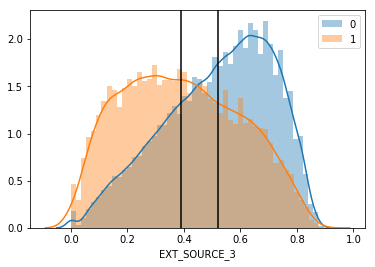

In [17]:
z_test(train_csv, 'TARGET', 'EXT_SOURCE_3', [0,1], kde=True)

EXT_SOURCE_2[TARGET == 0] mean=0.52, std=0.186
EXT_SOURCE_2[TARGET == 1] mean=0.41, std=0.213
z_score = 80.47, pvalue = 0.000, significantly different - True


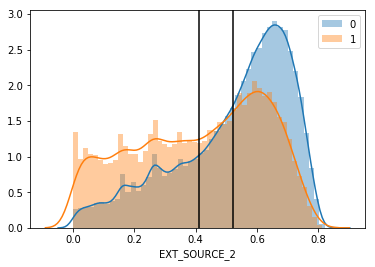

In [18]:
z_test(train_csv, 'TARGET', 'EXT_SOURCE_2', [0,1], kde=True)

In [19]:
#z_test(train_csv, 'CODE_GENDER', 'EXT_SOURCE_3', ['M','F'], kde=True)

In [20]:
#z_test(train_csv, 'CODE_GENDER', 'EXT_SOURCE_2', ['M','F'], kde=True)

In [21]:
#z_test(train_csv, 'CODE_GENDER', 'EXT_SOURCE_1', ['M','F'], kde=True)

EXT_SOURCE_1[TARGET == 0] mean=0.51, std=0.209
EXT_SOURCE_1[TARGET == 1] mean=0.39, std=0.205
z_score = 58.55, pvalue = 0.000, significantly different - True


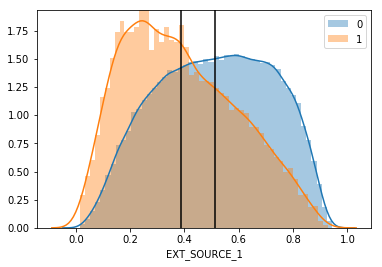

In [22]:
z_test(train_csv, 'TARGET', 'EXT_SOURCE_1', [0,1], kde=True)

In [23]:
#z_test(train_csv, 'CODE_GENDER', 'AMT_CREDIT', ['M','F'], kde=True)

In [24]:
#z_test(train_csv, 'CODE_GENDER', 'AMT_ANNUITY', ['M','F'], kde=True)

AMT_ANNUITY[TARGET == 0] mean=27163.62, std=14658.307
AMT_ANNUITY[TARGET == 1] mean=26481.74, std=12450.677
z_score = 8.15, pvalue = 0.000, significantly different - True


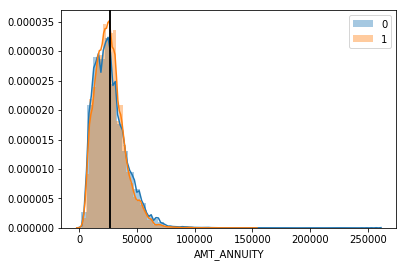

In [25]:
z_test(train_csv, 'TARGET', 'AMT_ANNUITY', [0,1], kde=True)

AMT_GOODS_PRICE[TARGET == 0] mean=542736.80, std=373785.494
AMT_GOODS_PRICE[TARGET == 1] mean=488972.41, std=311636.495
z_score = 25.60, pvalue = 0.000, significantly different - True


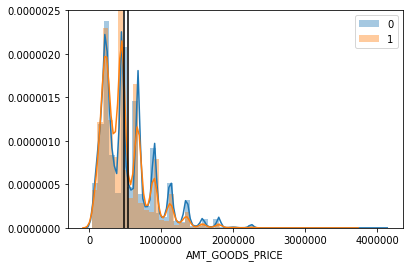

In [26]:
z_test(train_csv, 'TARGET', 'AMT_GOODS_PRICE', [0,1], kde=True)

In [27]:
#z_test(train_csv, 'CODE_GENDER', 'AMT_GOODS_PRICE', ['M','F'], kde=True)

In [28]:
pd.crosstab(train_csv['FLAG_OWN_CAR'], train_csv['TARGET'], normalize='index')

TARGET,0,1
FLAG_OWN_CAR,,
N,0.914998,0.085002
Y,0.927563,0.072437


AGE[TARGET == 0] mean=44.21, std=11.957
AGE[TARGET == 1] mean=40.78, std=11.487
z_score = 45.01, pvalue = 0.000, significantly different - True


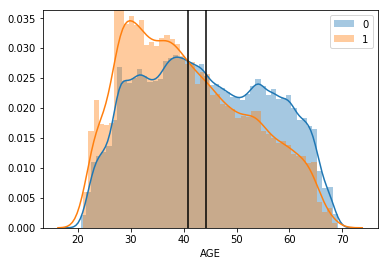

In [29]:
train_csv['AGE'] = train_csv.loc[:,'DAYS_BIRTH']/(-365.0)
z_test(train_csv, 'TARGET', 'AGE', [0,1], kde=True)

In [30]:
# days employed which doesn't follow the dataset rules
index1 = train_csv[train_csv['DAYS_EMPLOYED'] == 365243].index
index2 = train_csv[train_csv['DAYS_EMPLOYED'] > 0].index

train_csv.loc[index1,'DAYS_EMPLOYED'] = np.nan
train_csv.loc[index2,'DAYS_EMPLOYED'] = np.nan

MONTHS_EMPLOYED[TARGET == 0] mean=81.27, std=79.080
MONTHS_EMPLOYED[TARGET == 1] mean=60.50, std=61.658
z_score = 46.31, pvalue = 0.000, significantly different - True


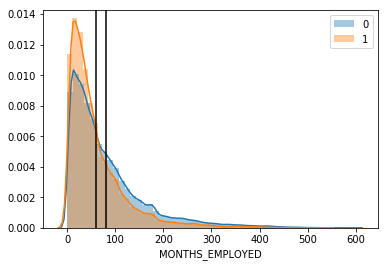

In [31]:
train_csv['MONTHS_EMPLOYED'] = train_csv.loc[:,'DAYS_EMPLOYED']/(-30.0)
z_test(train_csv, 'TARGET', 'MONTHS_EMPLOYED', [0,1], kde=True)

DAYS_REGISTRATION[TARGET == 0] mean=-5029.94, std=3538.464
DAYS_REGISTRATION[TARGET == 1] mean=-4487.13, std=3299.650
z_score = -24.70, pvalue = 0.000, significantly different - True


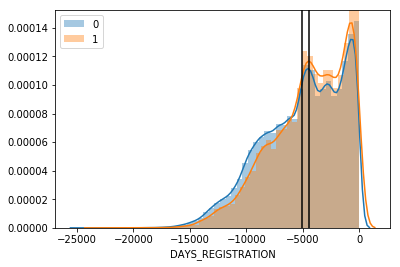

In [32]:
z_test(train_csv, 'TARGET', 'DAYS_REGISTRATION', [0,1], kde=True)

DAYS_ID_PUBLISH[TARGET == 0] mean=-3017.22, std=1506.614
DAYS_ID_PUBLISH[TARGET == 1] mean=-2732.10, std=1516.975
z_score = -28.41, pvalue = 0.000, significantly different - True


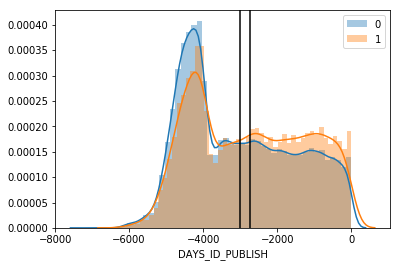

In [33]:
z_test(train_csv, 'TARGET', 'DAYS_ID_PUBLISH', [0,1], kde=True)

OWN_CAR_AGE[TARGET == 0] mean=11.94, std=11.891
OWN_CAR_AGE[TARGET == 1] mean=13.67, std=12.499
z_score = -11.66, pvalue = 0.000, significantly different - True


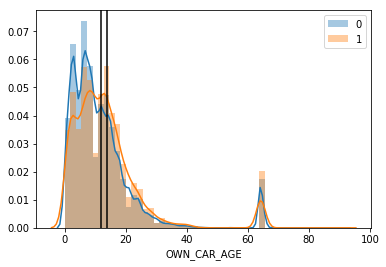

In [34]:
z_test(train_csv, 'TARGET', 'OWN_CAR_AGE', [0,1], kde=True)

In [35]:
pd.crosstab(train_csv['FLAG_MOBIL'], train_csv['TARGET'])

TARGET,0,1
FLAG_MOBIL,,
0,1,0
1,282685,24825


In [36]:
pd.crosstab(train_csv['FLAG_EMP_PHONE'], train_csv['TARGET'], normalize='index')

TARGET,0,1
FLAG_EMP_PHONE,,
0,0.945997,0.054003
1,0.913400,0.086600


In [37]:
pd.crosstab(train_csv['OBS_30_CNT_SOCIAL_CIRCLE'], train_csv['TARGET'], normalize='index')

TARGET,0,1
OBS_30_CNT_SOCIAL_CIRCLE,,
0.0,0.920993,0.079007
1.0,0.920157,0.079843
2.0,0.917539,0.082461
3.0,0.917577,0.082423
4.0,0.911758,0.088242
5.0,0.916571,0.083429
6.0,0.912444,0.087556
7.0,0.906378,0.093622
8.0,0.917088,0.082912


In [38]:
pd.crosstab(train_csv['OBS_60_CNT_SOCIAL_CIRCLE'], train_csv['TARGET'], normalize='index')

TARGET,0,1
OBS_60_CNT_SOCIAL_CIRCLE,,
0.0,0.920925,0.079075
1.0,0.920319,0.079681
2.0,0.917759,0.082241
3.0,0.917388,0.082612
4.0,0.911659,0.088341
5.0,0.915672,0.084328
6.0,0.911010,0.088990
7.0,0.909991,0.090009
8.0,0.916840,0.083160


In [39]:
pd.crosstab(train_csv['TARGET'], train_csv['AMT_REQ_CREDIT_BUREAU_HOUR'], normalize='columns')

AMT_REQ_CREDIT_BUREAU_HOUR,0.0,1.0,2.0,3.0,4.0
TARGET,,,,,
0,0.922827,0.919872,0.892857,1.0,1.0
1,0.077173,0.080128,0.107143,0.0,0.0


In [40]:
pd.crosstab(train_csv['TARGET'], train_csv['AMT_REQ_CREDIT_BUREAU_DAY'], normalize='columns')

AMT_REQ_CREDIT_BUREAU_DAY,0.0,1.0,2.0,3.0,4.0,5.0,6.0,8.0,9.0
TARGET,,,,,,,,,
0,0.922904,0.903251,0.896226,0.955556,0.884615,1.0,1.0,1.0,1.0
1,0.077096,0.096749,0.103774,0.044444,0.115385,0.0,0.0,0.0,0.0


In [41]:
pd.crosstab(train_csv['TARGET'], train_csv['AMT_REQ_CREDIT_BUREAU_WEEK'], normalize='columns')

AMT_REQ_CREDIT_BUREAU_WEEK,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
TARGET,,,,,,,,,
0,0.922841,0.922271,0.899497,0.931034,0.882353,0.9,0.95,1.0,1.0
1,0.077159,0.077729,0.100503,0.068966,0.117647,0.1,0.05,0.0,0.0


In [42]:
pd.crosstab(train_csv['TARGET'], train_csv['AMT_REQ_CREDIT_BUREAU_WEEK'], normalize='columns')

AMT_REQ_CREDIT_BUREAU_WEEK,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
TARGET,,,,,,,,,
0,0.922841,0.922271,0.899497,0.931034,0.882353,0.9,0.95,1.0,1.0
1,0.077159,0.077729,0.100503,0.068966,0.117647,0.1,0.05,0.0,0.0


In [43]:
pd.crosstab(train_csv['TARGET'], train_csv['NAME_EDUCATION_TYPE'], normalize='columns')

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
TARGET,,,,,
0,0.981707,0.946449,0.91515,0.890723,0.910601
1,0.018293,0.053551,0.08485,0.109277,0.089399


In [44]:
pd.crosstab(train_csv['TARGET'], train_csv['NAME_INCOME_TYPE'], normalize='columns')

NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Unemployed,Working
TARGET,,,,,,,,
0,1.0,0.925157,0.6,0.946136,0.94245,1.0,0.636364,0.904115
1,0.0,0.074843,0.4,0.053864,0.05755,0.0,0.363636,0.095885


In [45]:
pd.crosstab(train_csv['TARGET'], train_csv['NAME_FAMILY_STATUS'], normalize='columns')

NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Unknown,Widow
TARGET,,,,,,
0,0.900554,0.924401,0.918058,0.901923,1.0,0.941758
1,0.099446,0.075599,0.081942,0.098077,0.0,0.058242


In [46]:
pd.crosstab(train_csv['TARGET'], train_csv['NAME_HOUSING_TYPE'], normalize='columns')

NAME_HOUSING_TYPE,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents
TARGET,,,,,,
0,0.920677,0.922043,0.914603,0.934276,0.876869,0.883019
1,0.079323,0.077957,0.085397,0.065724,0.123131,0.116981


In [47]:
pd.crosstab(train_csv['TARGET'], train_csv['CNT_FAM_MEMBERS'], normalize='columns')

CNT_FAM_MEMBERS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,20.0
TARGET,,,,,,,,,,,,,,,,,
0,0.916356,0.924165,0.912397,0.913512,0.90598,0.865196,0.925926,0.7,1.0,0.666667,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1,0.083644,0.075835,0.087603,0.086488,0.09402,0.134804,0.074074,0.3,0.0,0.333333,1.0,0.0,1.0,0.0,0.0,0.0,0.0


--------------------- Confusion Matrix ---------------------
[[282686      0]
 [ 24825      0]]


--------------------- Classification Report ---------------------
             precision    recall  f1-score   support

          0       0.92      1.00      0.96    282686
          1       0.00      0.00      0.00     24825

avg / total       0.85      0.92      0.88    307511





C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


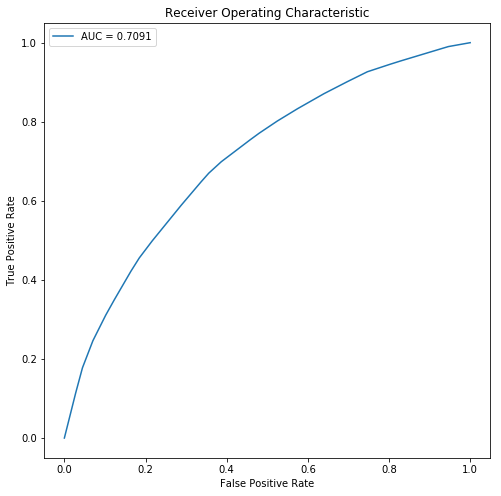

In [430]:
features = ['DAYS_EMPLOYED', 'AGE', 'CODE_GENDER', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
X = pd.get_dummies(train_csv.drop('TARGET', axis=1).fillna(0))
y = train_csv['TARGET']

model = decision_tree(X,y)
#regress_log(X,y)